In [9]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [9]:
# Build the model

# สร้าง custom model ด้วยการ sub class จาก Model Superclass
class MyModel(Model):
    def __init__(self):
        # ให้ object จาก subclass MyModel เรียก method __init__() จาก Superclass Model
        # เพื่อ __init__ เอา method , artibute จาก Model superclass มา
        super(MyModel, self).__init__()
        
        # custom artibute ของ sub-class
        # ให้ define layer ที่จะใช้ตรงนี้
        self.dense_1 = Dense(64,activation='relu')
        self.dense_2 = Dense(10)
        self.dropout = Dropout(0.4)
    
    # Forward pass ด้วย method call
    # รับ argument เป็น input ของโมเดล 
    def call(self, inputs, training = True): # training ใช้ควบคุมกลไกเช่น dropout ให้ทำงานเฉพาะตอนเทรน
        x = self.dense_1(inputs)
        if training:
            x = self.dropout(x)
        return self.dense_2(x) # return output
    

In [13]:
# ลองสร้างโมเดลแบบที่ ใช้ concatenate layer จากโมเดลที่มีหลาย path
# ตัวอย่างเช่นเอาไปใช้กับ Resnet

# สร้าง custom model ด้วยการ sub class จาก Model Superclass
class MyModel(Model):
    def __init__(self):
        # ให้ object จาก subclass MyModel เรียก method __init__() จาก Superclass Model
        # เพื่อ __init__ เอา method , artibute จาก Model superclass มา
        super(MyModel, self).__init__()
        
        # custom artibute ของ sub-class
        # ให้ define layer ที่จะใช้ตรงนี้
        self.dense_1 = Dense(64,activation='relu')
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()
        
    # Forward pass ด้วย method call
    # รับ argument เป็น input ของโมเดล 
    def call(self, inputs): 
        # branch 1 
        x = self.dense_1(inputs)
        # brach 2 
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)
        # concatenate layer
        concat = concatenate([x,y2])
        return self.softmax(concat) # return output

In [14]:
# Print the model summary

model = MyModel() # สร้างmodel instance (ยังไม่มี weight เพราะยังไม่รู้ input shape)
model(tf.random.uniform([1,10])) # ป้อน input
model.summary()

Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              multiple                  704       
_________________________________________________________________
dense_10 (Dense)             multiple                  110       
_________________________________________________________________
dense_11 (Dense)             multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [22]:
# Create a custom layer
# สร้าง linear custom layer

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        # ประกาศ weight ใน layer
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal')
        # ประกาศ bias
        self.b = self.add_weight(shape=(units,),
                        initializer='zeros')
        
    def call(self,inputs):
        # operation ใน layer
        # Linear layer = matrix multiplication + bias
        return tf.matmul(inputs,self.w) + self.b

# ประกาศ layer instance input_dim = 5 , units = 3
# สามารถทำให้ layer มี flexible input , output ได้โดยไม่ต้องประกาศ (ดูใน notebook flexible input)
dense_layer = MyLayer(3,5)

# dummy input 1 example , dimension = 5
x = tf.ones((1,5))

print(dense_layer(x)) # call layer ด้วย input จะได้ output tensor (functional API)
print(dense_layer.weights)

tf.Tensor([[-0.01061127 -0.01880332 -0.11153204]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.03029177, -0.07211334,  0.05287428],
       [ 0.08075985,  0.05233647, -0.02103471],
       [-0.09019319,  0.0266133 , -0.09011909],
       [ 0.00789479,  0.00814397, -0.01097611],
       [-0.03936448, -0.03378372, -0.04227641]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [11]:
# Specify trainable weights

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        # ประกาศ weight ใน layer
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal',
                                trainable = False) # ทำให้ weight freeze
        # ประกาศ bias
        self.b = self.add_weight(shape=(units,),
                                initializer='zeros',
                                trainable = False) # ทำให้ bias freeze
        
    def call(self,inputs):
        # operation ใน layer
        # Linear layer = matrix multiplication + bias
        return tf.matmul(inputs,self.w) + self.b


dense_layer = MyLayer(3,5)

In [12]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [15]:
# Create a custom layer to accumulate means of output values

# ตัวอย่างเลเยอรฺ์ ที่คำนวน mean ของผลรวม activation ทุก example
class MyLayerMean(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                        initializer='zeros')
        # sum ของ activation ในแต่ละ unit 
        self.sum_activation = tf.Variable(initial_value =tf.zeros((units,)), 
                                          trainable = False)
        # จำนวนครั้งที่layer คำนวน activation
        self.sum_number_call = tf.Variable(initial_value =0,
                                          trainable = False)
        
    def call(self,inputs):
        # คำนวน activation (axis = 0 example , axis 1 = activation)
        activations = tf.matmul(inputs,self.w) + self.b
        # sum activation along example dimension
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis = 0))
        # จำนวน example = axis 0
        self.sum_number_call.assign_add(inputs.shape[0])
        # return activation output และ ค่า mean
        return  activations ,self.sum_activation/tf.cast(self.sum_number_call,tf.float32)

dense_layer = MyLayerMean(3,5)

In [18]:
# Test the layer

# ที่เห็นค่า meanเท่าเดิมเพราะไม่ได้ update weight , bias (mean เลยออกมาค่าเดิม)

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[ 0.08340542  0.285719   -0.10238759]
[ 0.08340542  0.285719   -0.10238759]
[ 0.08340543  0.285719   -0.1023876 ]
[ 0.08340543  0.285719   -0.1023876 ]
[ 0.08340543  0.285719   -0.1023876 ]


In [19]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate= self.rate)

#### Implement the custom layers into a model

In [29]:
# Build the model using custom layers with the model subclassing API
# ใช้ custom layer กับ custom model

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        # ระวังเรื่อง unit ใส่ผิด
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)  
        self.softmax = Softmax()
        
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x) # relu layer ให่ เป็น non-linear
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x) # relu layer ให่ เป็น non-linear
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

In [30]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.00926016 0.03405553 0.01911923 0.01010063 0.01201754 0.01365427
  0.02169527 0.01338325 0.00870909 0.02102921 0.02418525 0.01354714
  0.00967997 0.00543655 0.00313296 0.01810955 0.03556857 0.06157813
  0.01129743 0.02284741 0.01910538 0.03596752 0.01075289 0.00828167
  0.00522606 0.04838146 0.0334566  0.01225133 0.0325416  0.01858398
  0.05553785 0.02601054 0.01458493 0.00917615 0.01423247 0.01005909
  0.02050249 0.01161873 0.01443289 0.06123981 0.01767377 0.0217004
  0.0277402  0.02904893 0.02720387 0.04628224]], shape=(1, 46), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_11 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_1 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_12 (MyLaye

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

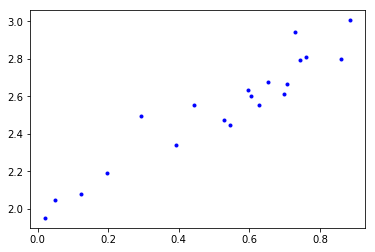

In [6]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

# เดี๋ยวเราจะสร้างโมเดลเพือหา m กับ b
m=1 
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [8]:
from tensorflow.keras.layers import Layer

In [10]:
# Build a custom layer for the linear regression model

# เราจะหา weight m และ bias b ด้วยโมเดล linear regression 

class LinearLayer(Layer):
    
    def __init__(self):
        super(LinearLayer, self).__init__()
        # ประกาศ weight ใน layer
        self.m = self.add_weight(shape=(1,),
                                initializer='random_normal')
        # ประกาศ bias
        self.b = self.add_weight(shape=(1,),
                        initializer='zeros')
        
    def call(self,inputs):
        return self.m*inputs + self.b
    
linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)


tf.Tensor(
[-0.00484505 -0.00559856 -0.00709331 -0.00503607 -0.00595519 -0.00584327
 -0.00313472 -0.0042266  -0.00477512 -0.00040605 -0.0001776  -0.00610149
 -0.00355726 -0.00688516 -0.00437887 -0.00099727 -0.0052453  -0.00158806
 -0.00235227 -0.00565932], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.0080205], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [11]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.523322


#### Train and plot the model

In [14]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):
    
    with tf.GradientTape() as tape:
        # tape จะเก็บ operation ที่กระทำกับ variable m , b ใน linear layer ไว้
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions,y_train)
        
    # คำนวน gradient dloss/dm , dloss/db
    gradients = tape.gradient(loss ,linear_regression.trainable_variables)
    
    # update wieght m , bias b (gradient descent)
    linear_regression.m.assign_sub(learning_rate * gradients[0]) # gradient[0] = m
    linear_regression.b.assign_sub(learning_rate * gradients[1]) # gradient[1] = b
    
    print("Step %d, loss, %f" % (i, loss.numpy()))

Step 0, loss, 4.953090
Step 1, loss, 3.761279
Step 2, loss, 2.856689
Step 3, loss, 2.170104
Step 4, loss, 1.648983
Step 5, loss, 1.253450
Step 6, loss, 0.953240
Step 7, loss, 0.725379
Step 8, loss, 0.552432
Step 9, loss, 0.421164
Step 10, loss, 0.321532
Step 11, loss, 0.245911
Step 12, loss, 0.188514
Step 13, loss, 0.144949
Step 14, loss, 0.111883
Step 15, loss, 0.086786
Step 16, loss, 0.067738
Step 17, loss, 0.053280
Step 18, loss, 0.042306
Step 19, loss, 0.033976
Step 20, loss, 0.027654
Step 21, loss, 0.022856
Step 22, loss, 0.019214
Step 23, loss, 0.016449
Step 24, loss, 0.014351


m:1,  trained m:[1.0442796]
b:2,  trained b:[1.9169871]


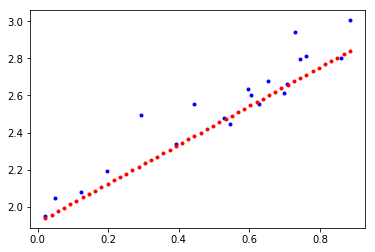

In [15]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [2]:
# Define the custom layers and model

class MyLayer(Layer):
    
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units
        
    def build(self,input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), # weight dimension คือ (n-1,n) input_shape[-1] = column ของ input
                                initializer='random_normal',
                                name = 'kernel')
        self.b = self.add_weight(shape=(self.units,),
                        initializer='zeros',
                        name = 'bias')
        
    def call(self,inputs):
        return tf.matmul(inputs,self.w) + self.b
    
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        return tf.nn.dropout(inputs, rate= self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        # ระวังเรื่อง unit ใส่ผิด
        self.layer_1 = MyLayer(units_1) # กำหนดแค่ unit เพราะ input flexible แล้ว
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2) # กำหนดแค่ unit เพราะ input flexible แล้ว
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3) # กำหนดแค่ unit เพราะ input flexible แล้ว
        self.softmax = Softmax()
        
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x) # relu layer ให่ เป็น non-linear
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x) # relu layer ให่ เป็น non-linear
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

In [9]:
# Instantiate the model object

model = MyModel(64,64,46)
print(model(tf.ones((1,10000))))
model.summary()

tf.Tensor(
[[0.00324969 0.0077365  0.00772192 0.04186173 0.02784719 0.01680296
  0.00438657 0.0714908  0.07739151 0.00422285 0.02774871 0.00882435
  0.01283436 0.00963543 0.0065447  0.01079877 0.02937825 0.00711894
  0.04105571 0.07877436 0.00366227 0.0369767  0.00233744 0.00477104
  0.04739881 0.00248068 0.00832825 0.01029946 0.00492874 0.01516151
  0.03174558 0.00318671 0.01536831 0.00866539 0.01244811 0.05773087
  0.05823107 0.04081864 0.00638842 0.00443793 0.05147238 0.01841066
  0.00722017 0.03840232 0.01245719 0.0012461 ]], shape=(1, 46), dtype=float32)
Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_6 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_4 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_7 (MyLaye

#### Load the reuters dataset and define the class_names 

In [5]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


In [6]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [7]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [13]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [13]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [10]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    # ปรับแต่ง loss โดยการ add weight penalty ให้กับกับ SparseCategoricalCrossentropy
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [17]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [22]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
train_dataset = train_dataset.batch(32)

# เก็บค่า loss ไว้ plot
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

# loop ใหญ่ epoch (process ทั้ง dataset)
for epoch in range(num_epochs):
    #กำหนด metrics ไว้ evaluation เวลา จบ epoch
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Training loop step ทีละ batch จนจบ dataset
    for x,y in train_dataset: #train_dataset object เป็น iterable ทีละ batch x,y
        # predict , คำนวน loss, คำนวน gradient จากฟังก์ชั่นที่เราสร้าง 
        loss_value , grads = grad(model, x, y, weight_decay)
        # update weight ด้วย optimizer
        optimizer.apply_gradients(zip(grads,model.trainable_variables)) # ต้องจับคู่ gradient กับ weight
        
        # Compute current loss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y),model(x))
    
    # จบ epoch add loss , accuracy ไว้กับ list เอาไว้ plot
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,epoch_loss_avg.result(),epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss: 3.281, Accuracy: 49.143%
Epoch 001: Loss: 1.907, Accuracy: 62.503%
Epoch 002: Loss: 1.807, Accuracy: 66.555%
Epoch 003: Loss: 1.773, Accuracy: 68.047%
Epoch 004: Loss: 1.757, Accuracy: 68.804%
Epoch 005: Loss: 1.731, Accuracy: 69.483%
Epoch 006: Loss: 1.721, Accuracy: 70.029%
Epoch 007: Loss: 1.725, Accuracy: 69.918%
Epoch 008: Loss: 1.707, Accuracy: 70.530%
Epoch 009: Loss: 1.692, Accuracy: 71.031%
Duration :242.556


#### Evaluate the model

In [23]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [24]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [25]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.827
Test accuracy: 67.988%


#### Plot the learning curves

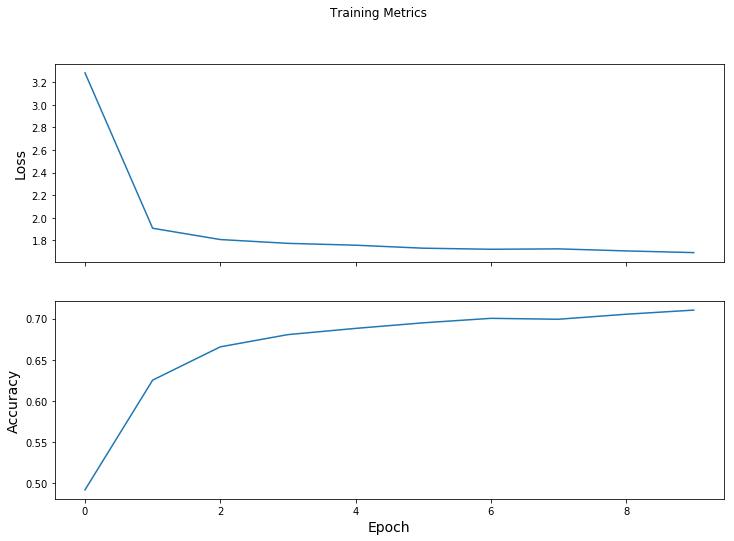

In [26]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [27]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [4]:
# Initialize a new model

model = MyModel(64,64,46)

#### Redefine the grad function using the @tf.function decorator

In [11]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [14]:
# Re-run the training loop
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
train_dataset = train_dataset.batch(32)

# เก็บค่า loss ไว้ plot
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

# loop ใหญ่ epoch (process ทั้ง dataset)
for epoch in range(num_epochs):
    #กำหนด metrics ไว้ evaluation เวลา จบ epoch
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Training loop step ทีละ batch จนจบ dataset
    for x,y in train_dataset: #train_dataset object เป็น iterable ทีละ batch x,y
        # predict , คำนวน loss, คำนวน gradient จากฟังก์ชั่นที่เราสร้าง 
        loss_value , grads = grad(model, x, y, weight_decay)
        # update weight ด้วย optimizer
        optimizer.apply_gradients(zip(grads,model.trainable_variables)) # ต้องจับคู่ gradient กับ weight
        
        # Compute current loss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y),model(x))
    
    # จบ epoch add loss , accuracy ไว้กับ list เอาไว้ plot
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,epoch_loss_avg.result(),epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 3.308, Accuracy: 49.755%
Epoch 001: Loss: 1.917, Accuracy: 61.323%
Epoch 002: Loss: 1.829, Accuracy: 65.910%
Epoch 003: Loss: 1.773, Accuracy: 68.058%
Epoch 004: Loss: 1.755, Accuracy: 69.038%
Epoch 005: Loss: 1.735, Accuracy: 69.417%
Epoch 006: Loss: 1.721, Accuracy: 69.728%
Epoch 007: Loss: 1.713, Accuracy: 70.630%
Epoch 008: Loss: 1.706, Accuracy: 70.163%
Epoch 009: Loss: 1.693, Accuracy: 71.087%
Duration :215.114


#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))